# Predict Antibiotic resistance in Escherichia coli using SNP data 🧬  
# | Sci-kit Learn & Keras
---
Single nucleotide polymorphim (SNP) data has the capacity to identify multi-drug Antibiotic resistance (ABR) and is crucial for prediction and analytical purposes. The Data was attained from Y. Ren (2021) as a SNP matrix of E. coli samples against the antibiotics; Ciprofloxacin (CIP), cefotazime (CTX), ceftazidime (CIZ) and gentacin (GEN).


Results indiciated the following best approach for the multilabel, unbalanced over-featurized dataset:
- Random Forest feature selection
- Duplication oversampling   
- Stacking (RF + SVC + LR)

Highest per antibiotic F1 scores where
- Ciprofloxacin = 0.95
- cefotazime = 0.84
- ceftazidime = 0.86
- gentacin = 0.83


---

*Ren, Y., Chakraborty, T., Doijad, S., Falgenhauer, L., Falgenhauer, J., Goesmann, A., Hauschild, A. C., Schwengers, O., & Heider, D. (2022). Prediction of antimicrobial resistance based on whole-genome sequencing and machine learning. Bioinformatics (Oxford, England), 38(2), 325–334. https://doi.org/10.1093/bioinformatics/btab681*




# Preprocessing

Here I prepare the dataset in a few ways

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, save_model
from keras import layers

import os
from functools import partial
from datetime import datetime

In [2]:
!pip install complexcgr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


In [3]:
%pip install -q -U tensorboard-plugin-profile
%load_ext tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 13.8 MB/s eta 0:00:00


In [4]:
%reload_ext tensorboard
!kill -9 7409

/bin/bash: line 1: kill: (7409) - No such process


## Tensorboard
A useful intefrace for tracking / evaluating tensorflow models

In [5]:
%tensorboard --logdir=./logs

<IPython.core.display.Javascript object>

In [6]:
!lsof -i:6006

COMMAND   PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
tensorboa 392 root    7u  IPv4  26394      0t0  TCP localhost:6006 (LISTEN)


## Setup

I have the dataset on google drive, as such this notebook doesnt automatically download it and wont work on other machines / accounts.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
dir = '/content/drive/MyDrive/datasets/'
snp_df = pd.read_csv(dir + 'cip_ctx_ctz_gen_multi_data.csv')
phenotype_df = pd.read_csv(dir + 'cip_ctx_ctz_gen_pheno.csv')
snp_df.head(3), phenotype_df.head(3)

(        prename  X393  X588  X747  X759  X774  X966  X1299  X1302  X1407  ...  \
 0  H100_S2_L001     2     1     2     4     3     3      3      3      4  ...   
 1  H105_S3_L001     2     1     2     4     3     3      3      3      4  ...   
 2  H108_S5_L001     2     1     2     4     3     3      0      0      4  ...   
 
    X4639956.3  X4640785.3  X4640908.3  X4640924.3  X4641031.3  X4641131.3  \
 0           3           4           4           2           1           3   
 1           3           4           4           2           1           3   
 2           3           4           4           2           1           3   
 
    X4641217.3  X4641296.3  X4641439.3  X4641440.3  
 0           1           3           3           1  
 1           1           3           3           1  
 2           1           3           3           1  
 
 [3 rows x 60937 columns],
         prename  CIP  CTX  CTZ  GEN
 0  H100_S2_L001    0    1    0    0
 1  H105_S3_L001    1    1    0    0
 2  

In [9]:
snp_df.columns[14_972], snp_df.columns[14_973]

('X4641440', 'X393.1')

In [10]:
snp_df = snp_df.iloc[:, :14_972]
snp_df.head(3)

,prename,X393,X588,X747,X759,X774,X966,X1299,X1302,X1407,...,X4639956,X4640785,X4640908,X4640924,X4641031,X4641131,X4641208,X4641217,X4641296,X4641439
0,H100_S2_L001,2,1,2,4,3,3,3,3,4,...,3,4,4,2,1,3,4,1,3,3
1,H105_S3_L001,2,1,2,4,3,3,3,3,4,...,3,4,4,2,1,3,4,1,3,3
2,H108_S5_L001,2,1,2,4,3,3,0,0,4,...,3,4,4,2,1,3,4,1,3,3


In [11]:
snp_df.columns = snp_df.columns.str[1:]
snp_df.head(3)

,rename,393,588,747,759,774,966,1299,1302,1407,...,4639956,4640785,4640908,4640924,4641031,4641131,4641208,4641217,4641296,4641439
0,H100_S2_L001,2,1,2,4,3,3,3,3,4,...,3,4,4,2,1,3,4,1,3,3
1,H105_S3_L001,2,1,2,4,3,3,3,3,4,...,3,4,4,2,1,3,4,1,3,3
2,H108_S5_L001,2,1,2,4,3,3,0,0,4,...,3,4,4,2,1,3,4,1,3,3


In [12]:
snp_loci = np.array(list(snp_df.columns)[1:], dtype=np.int32)
snp_loci

array([    393,     588,     747, ..., 4641217, 4641296, 4641439],
      dtype=int32)

In [13]:
snp_df.info

<bound method DataFrame.info of                   rename  393  588  747  759  774  966  1299  1302  1407  ...  \
0           H100_S2_L001    2    1    2    4    3    3     3     3     4  ...   
1           H105_S3_L001    2    1    2    4    3    3     3     3     4  ...   
2           H108_S5_L001    2    1    2    4    3    3     0     0     4  ...   
3           H109_S2_L001    2    1    2    4    3    3     3     3     4  ...   
4           H113_S6_L001    0    0    2    4    3    3     3     3     4  ...   
..                   ...  ...  ...  ...  ...  ...  ...   ...   ...   ...  ...   
804  wwRBK-17-0298-1_S42    0    0    2    4    3    3     0     0     4  ...   
805   wwRBK-17-075-1_S28    2    1    2    4    3    3     3     3     4  ...   
806   wwRBL-16-111-1_S16    2    0    0    0    3    0     3     3     4  ...   
807   wwRBL-17-004-1_S44    2    1    2    4    3    3     3     3     4  ...   
808    WWSurvcare043_S43    2    1    2    4    3    3     3     3     4  ...

Introducing the Curse of dimensionality, where there are far more features than samples (806 vs 15,000). This requires some wiser methods of handeling dimensionality reduction.

In [14]:
snp_df.shape, phenotype_df.shape

((809, 14972), (809, 5))

In [15]:
phenotype_df.value_counts()

prename             CIP  CTX  CTZ  GEN
H100_S2_L001        0    1    0    0      1
RBT-18-0275-1_S63   0    0    0    0      1
RBT-18-0246-1_S52   0    0    0    0      1
RBT-18-0247-1_S16   1    1    1    1      1
RBT-18-0251-1_S7    0    0    0    0      1
                                         ..
RBG-18-0437-1_S54   1    1    0    0      1
RBK-16-007-1_S13    1    1    1    0      1
RBK-16-073-1_S14    0    1    1    0      1
RBK-16-079-1_S15    0    1    1    1      1
wwRBL-17-004-1_S44  1    1    1    1      1
Length: 809, dtype: int64

In [16]:
phenotype_df.value_counts()

prename             CIP  CTX  CTZ  GEN
H100_S2_L001        0    1    0    0      1
RBT-18-0275-1_S63   0    0    0    0      1
RBT-18-0246-1_S52   0    0    0    0      1
RBT-18-0247-1_S16   1    1    1    1      1
RBT-18-0251-1_S7    0    0    0    0      1
                                         ..
RBG-18-0437-1_S54   1    1    0    0      1
RBK-16-007-1_S13    1    1    1    0      1
RBK-16-073-1_S14    0    1    1    0      1
RBK-16-079-1_S15    0    1    1    1      1
wwRBL-17-004-1_S44  1    1    1    1      1
Length: 809, dtype: int64

In [17]:
ordered_AB_names = ["ciprofloxacin (CIP)", "cefotaxime (CTX)",
                    "ceftazidime  (CIZ)", "gentamicin (GEN)"]

In [18]:
from sklearn.model_selection import train_test_split

y = np.array(phenotype_df[['CIP', 'CTX', 'CTZ', 'GEN']])
X = np.array(snp_df.drop('rename', axis=1))

for i in X, y:
  i = np.asarray(i).astype('float32')

def split(X, y, test_size=0.2):
  dataset = train_test_split(X, y, test_size=test_size, random_state=0)
  for i in dataset:
    print(i.shape)

  return dataset

X_train, X_test, y_train, y_test = split(X, y)
unchanged_dataset = (X_train, X_test, y_train, y_test)

(647, 14971)
(162, 14971)
(647, 4)
(162, 4)


## One Hot Encoding
One Hot encoding (OHE) involves transforming categorical data to vectors which each entry corrospoending to a seperate category. The Resulting dataset contains sparse vectors with a single 1, significantly conserving the data size, where categoricies can exist indopendant by magnitude as apposed to basic tokenization. (However Some non-parametric models like random forest still prefer tokenization)

In [19]:
X_1hot = tf.one_hot(tf.constant(X), depth=5)
X_1hot[:3]

<tf.Tensor: shape=(3, 14971, 5), dtype=float32, numpy=
array([[[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]],

       [[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]],

       [[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]]], dtype=float32)>

In [20]:
X_1hot[:600].shape, y[:600].shape

(TensorShape([600, 14971, 5]), (600, 4))

In [21]:
onehot_dataset = X_1hot[:600], X_1hot[600:], y[:600], y[600:]

## Multi-lable SMOTE
As the dataset is imbalanced (significant less GIT present), I should adopt some way of giving this class equal (or more) attention during training.
https://github.com/niteshsukhwani/MLSMOTE.git provides a solution to synthetic minorty sampling technique (SMOTE) with multilabel data. However there were issues with the algorithm and it either wasnt working or i wasnt understanding it. Either way SMOTE is rarerly use for categorical data due to the difficulting of interperlating between 1hot vectors, see duplication oversamlping below.

In [22]:
!git clone https://github.com/niteshsukhwani/MLSMOTE.git

Cloning into 'MLSMOTE'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 4), reused 1 (delta 0), pack-reused 0
Receiving objects: 100% (18/18), 5.90 KiB | 5.90 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [23]:
def classes(y_df, height=600):
  plt.bar(y_res.sum().index, y_df.sum())
  plt.show()
  print("total samples: ", len(y_df))

In [24]:
%cd MLSMOTE
%ls
from mlsmote import *

/content/MLSMOTE
mlsmote.py  README.md


In [25]:
try:
  snp_df.drop("rename", axis=1, inplace=True)
  phenotype_df.drop("prename", axis=1, inplace=True)
except KeyError:
  print("assuming aleady dropped")

In [26]:
X_df_train, X_df_test = snp_df.iloc[:647], snp_df.iloc[647:]
y_df_train, y_df_test = phenotype_df[:647], phenotype_df[647:]

In [27]:
X_df_train.head()

,393,588,747,759,774,966,1299,1302,1407,1425,...,4639956,4640785,4640908,4640924,4641031,4641131,4641208,4641217,4641296,4641439
0,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,4,1,3,3
1,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,4,1,3,3
2,2,1,2,4,3,3,0,0,4,2,...,3,4,4,2,1,3,4,1,3,3
3,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,1,1,3,3
4,0,0,2,4,3,3,3,3,4,2,...,3,4,0,0,2,3,4,1,3,3


In [28]:
X_sub, y_sub = get_minority_instace(X_df_train, y_df_train)
X_res, y_res = MLSMOTE(X_sub, y_sub, 200)
X_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332 entries, 0 to 199
Columns: 14971 entries, 393 to 4641439
dtypes: float64(14971)
memory usage: 37.9 MB


In [29]:
y_sub.sum(), len(y_sub)

(CIP    113
 CTX    106
 CTZ     95
 GEN    132
 dtype: int64,
 132)

In [30]:
X_df_train = pd.concat([X_df_train, X_res])
y_df_train = pd.concat([y_df_train, y_res])

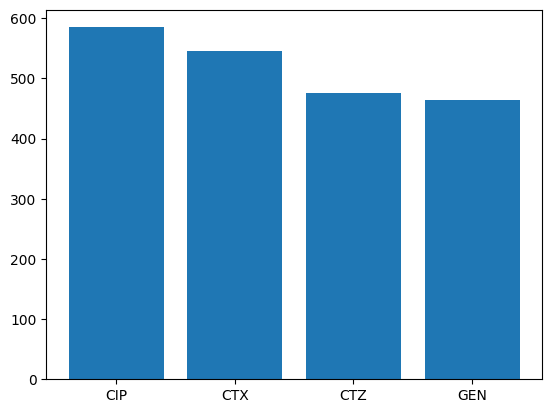

total samples:  979


In [31]:
classes(y_df_train)

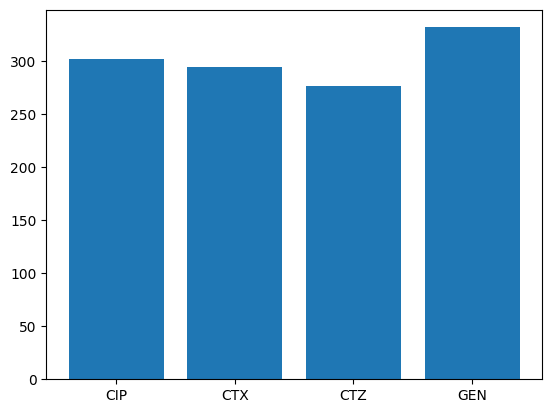

total samples:  332


In [32]:
classes(y_res)

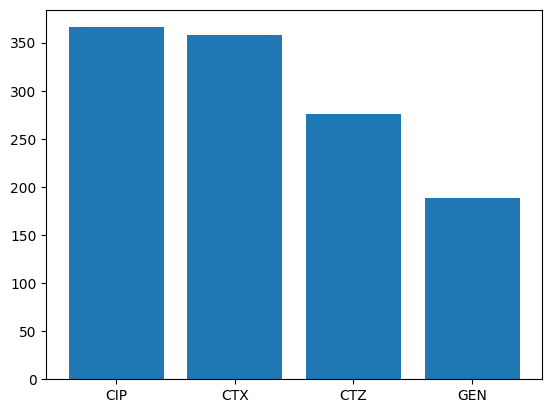

total samples:  809


In [33]:
classes(phenotype_df)

In [34]:
SMOTE_data = (X_res, X_df_test, y_res, y_df_test)

smote falls short for categorical/one hot encoded data as interpelating between knn points truncates dimensions and creates artefacts. Pure duplication should will suffice

## Random Duplication oversampling
Recommended oversampling technique in place of smote for this kind of data. Simply just duplicated random elements of the minority class to ensure to simulate larger batch-sizes during training to minimize underfitting.

132


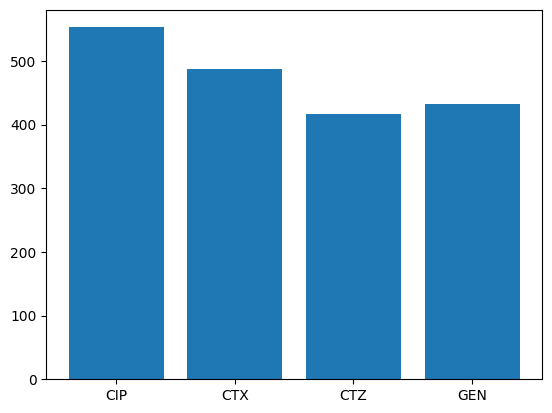

total samples:  947


In [35]:
import random

def minority_sampling(snp_df, phenotype_df, minority_class='GEN', shush=False):

  X_df_train, X_df_test = snp_df.iloc[:647], snp_df.iloc[647:]
  y_df_train, y_df_test = phenotype_df[:647], phenotype_df[647:]

  indices_to_duplicate = np.where(y_df_train[minority_class] == 1)[0]
  print(len(indices_to_duplicate))

  items_to_duplicate = np.random.choice(indices_to_duplicate, 300, replace=True)

  df_X_duplicated = X_df_train.iloc[items_to_duplicate].reset_index(drop=True)
  df_y_duplicated = y_df_train.iloc[items_to_duplicate].reset_index(drop=True)

  final_df_X = pd.concat([X_df_train, df_X_duplicated], ignore_index=True)
  final_df_y = pd.concat([y_df_train, df_y_duplicated], ignore_index=True)

  X_oversampled = np.concatenate([final_df_X, X_df_test])
  y_oversampled = np.concatenate([final_df_y, y_df_test])

  if not shush:
    classes(final_df_y)

  return (final_df_X, X_df_test, final_df_y, y_df_test)

final_df_X, X_df_test, final_df_y, y_df_test = minority_sampling(snp_df, phenotype_df)
oversampled_dataset = final_df_X, X_df_test, final_df_y, y_df_test

In [36]:
print("old GEN sample num: ", y_df_train.sum()["GEN"])
print("new GEN sample num: ", final_df_y.sum()["GEN"])

old GEN sample num:  464.0
new GEN sample num:  432


In [37]:
X_oversampled = np.concatenate([final_df_X, X_df_test])
y_oversampled = np.concatenate([final_df_y, y_df_test])
oversampled_dataset = (final_df_X, X_df_test, final_df_y, y_df_test)

In [38]:
X_1hot_train = tf.one_hot(tf.constant(final_df_X), depth=5)
X_1hot_test = tf.one_hot(tf.constant(X_df_test), depth=5)

In [39]:
oversampled_1hot_dataset = (X_1hot_train, X_1hot_test, final_df_y, y_df_test)

## Hash trick
Ignore this

In [40]:
X_oversampled.shape

(1109, 14971)

In [41]:
from sklearn.feature_extraction import FeatureHasher

dictionary_X = [
    {
        ordered_AB_names[0]: x[0],
        ordered_AB_names[1]: x[1],
        ordered_AB_names[2]: x[2],
        ordered_AB_names[3]: x[3],
    }
    for x in X_oversampled
]

n_features = 14971
hasher = FeatureHasher(n_features=n_features, input_type='dict')
hashed_features = hasher.transform(dictionary_X)

X_hashed = hashed_features.toarray()
X_hashed

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

incomplete

## Multiple Correspondence Analysis
Multiple Correspondence Analysis (MCA) is multilable alterative to the popular principle corrospondance analysis (PCA) for dimensionaloty reduction. It involves projecting down dimensions and tracking how much variance remains, then cut off a set amount of components that preserves a certain degree of variance (~95%).

In [42]:
!pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 5.0 MB/s eta 0:00:00


In [43]:
import prince

X_train, X_test, y_train, y_test = [np.array(set) for set in oversampled_dataset]

In [44]:
ca = prince.CA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
ca = ca.fit(pd.DataFrame(X_train))
# mca_transformed = ca.transform(X_train)
ca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.054,34.11%,34.11%
1,0.011,7.08%,41.19%
2,0.009,5.78%,46.97%


gave up :)

## Feature Selection
When all else fails, feature reduction can also be done selectively via a model with powerful feature tracability (Random Forest).
The Below strategy only retains 600 SNP positions with the highest importance using the gini impurity decrease method.

In [73]:
def feature_importance(model, cap=20):
  feature_importances = model.feature_importances_
  feature_importance_pairs = list(zip(snp_loci, feature_importances))
  sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
  # for feature_name, importance in sorted_feature_importance_pairs[:10]:
  #    print(f"{feature_name}: {importance}")

  loci = [str(x[0]) for x in sorted_feature_importance_pairs[:cap]]
  importance = [x[1] for x in sorted_feature_importance_pairs[:cap]]
  plt.barh(loci, importance, color="red")
  plt.ylabel("SNP location")
  plt.xlabel("relative importance")
  plt.show()


  return sorted_feature_importance_pairs

In [74]:
from sklearn.ensemble import RandomForestClassifier

X_rf_train, X_rf_test, y_rf_train, y_rf_test = oversampled_dataset
X_rf = np.concatenate([X_rf_train, X_rf_test]) # no test - feature importance
y_rf = np.concatenate([y_rf_train, y_rf_test])

# best params from below
rf = RandomForestClassifier(min_samples_split=2, n_estimators=200)
rf.fit(X_rf, y_rf)

RandomForestClassifier(n_estimators=200)

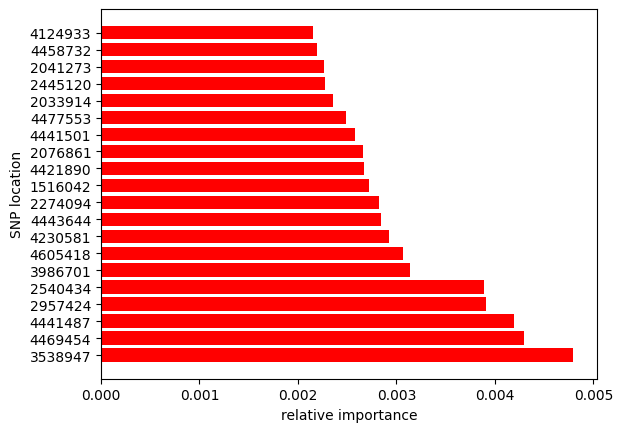

In [75]:
sorted_pairs = feature_importance(rf, cap=20)

In [76]:
from sklearn.model_selection import train_test_split

def selective_dataset(n_features=600, sorted_pairs=sorted_pairs):
  sorted_loci = [x[0] for x in sorted_pairs]
  X = np.array(snp_df[[str(i) for i in sorted_loci[:n_features]]])
  y = np.array(phenotype_df)

  ds = (X_train, X_test, y_train, y_test)= minority_sampling(
      snp_df[[str(i) for i in sorted_loci[:n_features]]], phenotype_df,
      shush=True
      )

  return ds

selective_oversampled_dataset = selective_dataset(n_features=600)

132


In [77]:
[i.shape for i in selective_oversampled_dataset]

[(947, 600), (162, 600), (947, 4), (162, 4)]

# Fequency Based Chaos Game Representation
Fequency Based Chaos Game Representation (FCGR) is a "rasterized" version of CGR, usually used in mathematical situations famous for creating fractals and pretty patterns. FCGR has gained popularoity in genomics for its ability to reqpresnt read sequences of categorical data, without alignment, and almost entirely conserve the resultant fractal, indopendant of the read order. Whilest this allows researchers to throw whole genome sequences into machine learning models without worring about alignment, other studies still use FCGR for SNP data for a simple forced dimenstionality reduction method. FCGR also promises very good results for parametric models (Shi, 2019).


*Shi, J., Yan, Y., Links, M. G., Li, L., Dillon, J. R., Horsch, M., & Kusalik, A. (2019). Antimicrobial resistance genetic factor identification from whole-genome sequence data using deep feature selection. BMC bioinformatics, 20(Suppl 15), 535. https://doi.org/10.1186/s12859-019-3054-4*


## Setup

In [ ]:
from Bio import SeqIO

In [ ]:
# use the overasmpled dataset
X_train, X_test, y_train, y_test = oversampled_dataset
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
X.shape, y.shape

((1109, 14971), (1109, 4))

In [ ]:
def fasta_to_list(fasta_file):
    records = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    all_sequences = "".join(str(record.seq) for record in records.values())
    wgs = list(all_sequences)
    return wgs

reference = fasta_to_list(dir + "ecoli_reference_k12.fasta")
def index_reference(i):
  return reference[i+1]

len(reference)

4641652

In [ ]:
ordered_bases = ['A','G','C','T']

def reverse_tokenize(base, position):
  if base == 0:
    return index_reference(position)
  else:
    return ordered_bases[base-1]

def reverse_map(sample):
  copy = list(sample.copy())
  for i, base in enumerate(copy):
    copy[i] = reverse_tokenize(base, snp_loci[i])

  return np.array(copy)

def display(sample):
  sample = np.array(sample)
  print(sample.shape, sample, np.unique(sample))

sample0 = X[597]
display(sample0)
new_sample0 = reverse_map(sample0)
display(new_sample0)

(14971,) [0 0 0 ... 0 0 0] [0 1 2 3 4]
(14971,) ['T' 'T' 'T' ... 'A' 'G' 'C'] ['A' 'C' 'G' 'T']


When detoknizing, Non-SNPs are replaces with the corrospoonding refrence genomes nucleotide.  

In [ ]:
X_detokenized = np.array([reverse_map(sample) for sample in X])
X_detokenized, X

(array([['G', 'A', 'G', ..., 'A', 'C', 'C'],
        ['G', 'A', 'G', ..., 'A', 'C', 'C'],
        ['G', 'A', 'G', ..., 'A', 'C', 'C'],
        ...,
        ['G', 'T', 'T', ..., 'A', 'G', 'C'],
        ['G', 'A', 'G', ..., 'A', 'C', 'C'],
        ['G', 'A', 'G', ..., 'A', 'C', 'C']], dtype='<U1'),
 array([[2, 1, 2, ..., 1, 3, 3],
        [2, 1, 2, ..., 1, 3, 3],
        [2, 1, 2, ..., 1, 3, 3],
        ...,
        [2, 0, 0, ..., 0, 0, 0],
        [2, 1, 2, ..., 1, 3, 3],
        [2, 1, 2, ..., 1, 3, 3]]))

sanity check

In [ ]:
X_detokenized.shape, X.shape

((1109, 14971), (1109, 14971))

In [ ]:
X_detokenized[7][4610], reference[4610+1]

('A', 'T')

In [ ]:
X_detokenized[3][0], reference[393]

('G', 'G')

In [ ]:
len(X[0]), len(snp_loci)

(14971, 14971)

In [ ]:
sample = X_detokenized[0]
''.join(sample)

'GAGTCCCCTGGGGGTCGTTGCGTAGCCCCCGCTTACAGCCCTCGGGAGAGGAATGGCGGCCTTGGACTTCGGGAGACGTGGCAGGCGTGAAGAGGTTTCCTCTGCCGGTGTAACGCACTCGCCTACGTCCCCCGTTGGTCAAACTGCGAAACGCGGCCCCTGTTGCGTGAGGGCCCCCTGCCTCGCCTTGTGCCGGCGCTGCCGTGGCAGGCTTCATCAGGCGCTAGATCTGGGAGCGCCCATACGGTGCTACCCTTCCCCGCGCGCGCCGGAGCATCGAGGGATCTGGGAAGATCGGACGTCGCCGGCCACTGGAGTTGCCCCATGCCGGGTGGCCCGCCCGAGCCAGTGCGGGGAGCGTGCGTACAGGCCCCGTGTCGAGACTGTAGTGTGGGCAGGCCCGCCGCAACAGCTCCTCCGTTGCAGGTCCCCGGCTCCAGTCAATGGGGAGGAATGCGACCCCTGGAAGCCGGACACAACGCCCGTCCCCCCCCCCTACGCGCCCGGCCCACTGCAGCCCCAATGCAGCCGGCTGCCTCCCGTTACAGTCCCCCTGACGGCCCATCGCCACCCCGGAGCTTGCCGGGCCATGGCCGCACCCCGTAGATGGTACGAAGTGAAGAAGGAGCAGGGCGGGCGGCACAGCGTAGTCTGGATGGTCGCCCCTGAGACCGGATGTTCGGGGACGCGCTGACATAGACCCCTGCGGACCGGGATTCGGTCAGCACTCCACTCCCCAGGCGCTCGGGACCACTCGGCAGCTGTAGCGCACTGGGGTCAGGACCCGATGTAGACATGACTGTGTCCGGCCCCCCGAGCGCGCAAGCGCGACGTGGAGGAGGCCGCATCACGACCCCACCCCAGGGAGTCCCAGTAAGGATAACCATCGGGCTAATCGACTCCTGACTCAACAGCTGCGGGAGCCCACGACGCAGAACCGCAAGCGGCTAGCGTCCCGGTCCCTCGGCGGGGCGTACGCAGGAAGGCGTTGCCCCCCCG

In [ ]:
sample = X_detokenized[597]
''.join(sample)

'TTTGTCGCTATTTTTCGGCAAGCCGCAATCTGCCAGTGCCAGGAGAATCGACGTGTCTTTGCGAAAGTCTATGCGCTTCTTGCCTATTTGGGATTTAATAAGGTAGCATGGCGGTAAGTCGCGGCCCGGTAGCTTGGAGCAATGGGCTACGGCACTCCATGTTAGGTATAATGTGATACGTCTGGGGAAGCAGAAATTTCAGCTCCCTCGTCGGGAGCACGAAGCACCCGCGAACGCTGTGTGGACGCTCCACTGCCACCCGTTGCCAGTTATCCGCCTCTGTCTGCCGCCCCGAGGGCCGTTGGCAGTTTCCTGAATTGCCCCATGCCGGATGGCCCCCCCAATCCAGTGCGGGGGGCGTGCGTATGGGCCCCGCGCGGAGATTGTAGTGTGGGCAGGCCCGCCGCAACAGCTCGACCGTTGCAGAGTCGCGCGCCGCCACGCCAACCTCTCATGCCGATTTATTATAGCCTGCGTCAAGCTGTGTGCAGTTCCTTATTAATCGTCTTGTTTCGCTGAGGCCCACGTTGGGCGGTAATGACCAAGCGACGAGCATCATCACCGCGTGAATGGTGCACACCCTTCCTGGAGCGAGCTCGTCCGCGCGTAAACTATCGTCAAGACGCCGTCCCCCTATGGGAACCGGATACTCTGGATTTAGTGCACAGCTTGGCCCCAAGCCAGGACTGGCTGACATAGACCTCTGCGGACCGCGGCGCTGTCTGGGCCCTCGTGTGTTGTGTTCCTGGCGGTATGGTTTTACCTAGCGGTAGTACGTAATTTGCGGACGTCATCTTAATTGTCATCGGTTGGCAATTAGACTAGTGCCTACTAAGATGGGGCTCTTGGGGAGCCGAAGACCATCTTGTAGACCAAAGGATATGCCTCCCGGGAATCGACTCCTGAATCACCACTTCGGGGAGCCCACGACCGTCCGCCTTCGACGTGATTGTGAAAACTCCAAGTGCAATGCTGCACCTCTCTTACCGCGTCCCCCAG

In [ ]:
from complexcgr import FCGR

fcgr = FCGR(k=6)

X_fcgr = np.array([fcgr(''.join(sample)) for sample in X_detokenized])

print(X_fcgr.shape)

(1109, 64, 64)


In [ ]:
fcgr_dataset = X_fcgr_train, X_fcgr_test, y_fcgr_train, y_fcgr_test = train_test_split(X_fcgr, y, test_size=0.2, random_state=0)
for i in fcgr_dataset:
  print(i.shape)

(887, 64, 64)
(222, 64, 64)
(887, 4)
(222, 4)


## Analysis

In [ ]:
from PIL import Image

# enable image scaling to FCGR library
class FCGR_SCALABLE(FCGR):
  scale = None

  def array2img(self, array):
    img = super().array2img(array)
    if self.scale:
      return img.resize(self.scale, resample=Image.NEAREST)
    else:
      return img

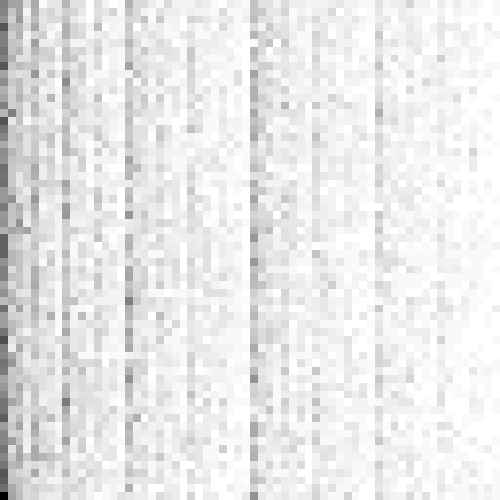

In [ ]:
fcgr = FCGR_SCALABLE(k=6)
fcgr.scale = (500, 500)
sample = X_detokenized[0]
chaos = fcgr(''.join(sample))
fcgr.plot(chaos)

In [ ]:
import random; random.seed(0)

def plot_group(
    index_range=[random.randint(0, 800) for _ in range(25)],
    y_axis=[""]*5,
):
  fcgr = FCGR_SCALABLE(k=4)
  fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 10))

  for i, ax in zip(index_range, axes.flat):
    sample = X_detokenized[i]
    chaos = fcgr(''.join(sample))
    image = fcgr.plot(chaos)

    ax.imshow(np.array(image))
    ax.set_title(f"{i}: {y[i]}")


  plt.tight_layout()
  plt.show()

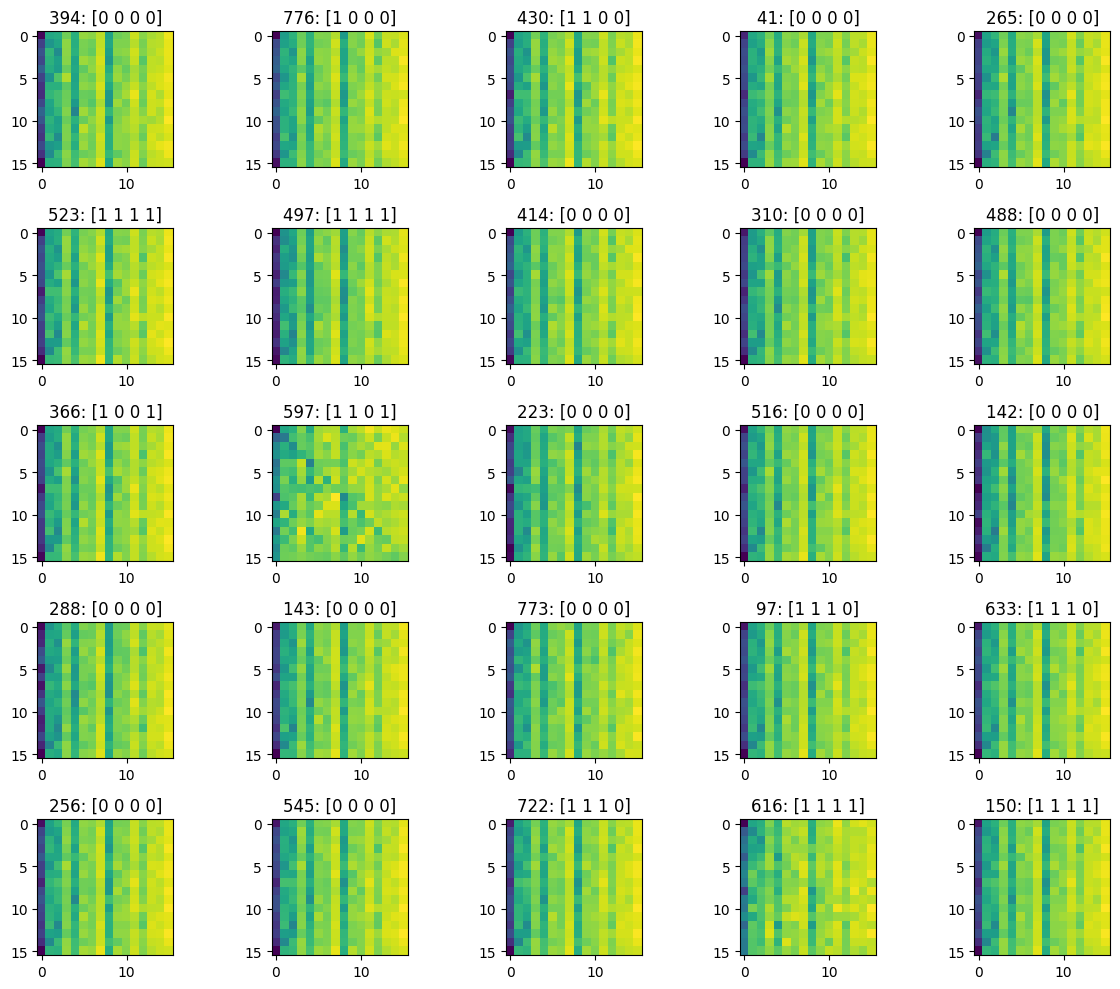

In [ ]:
plot_group()

no clear pattern

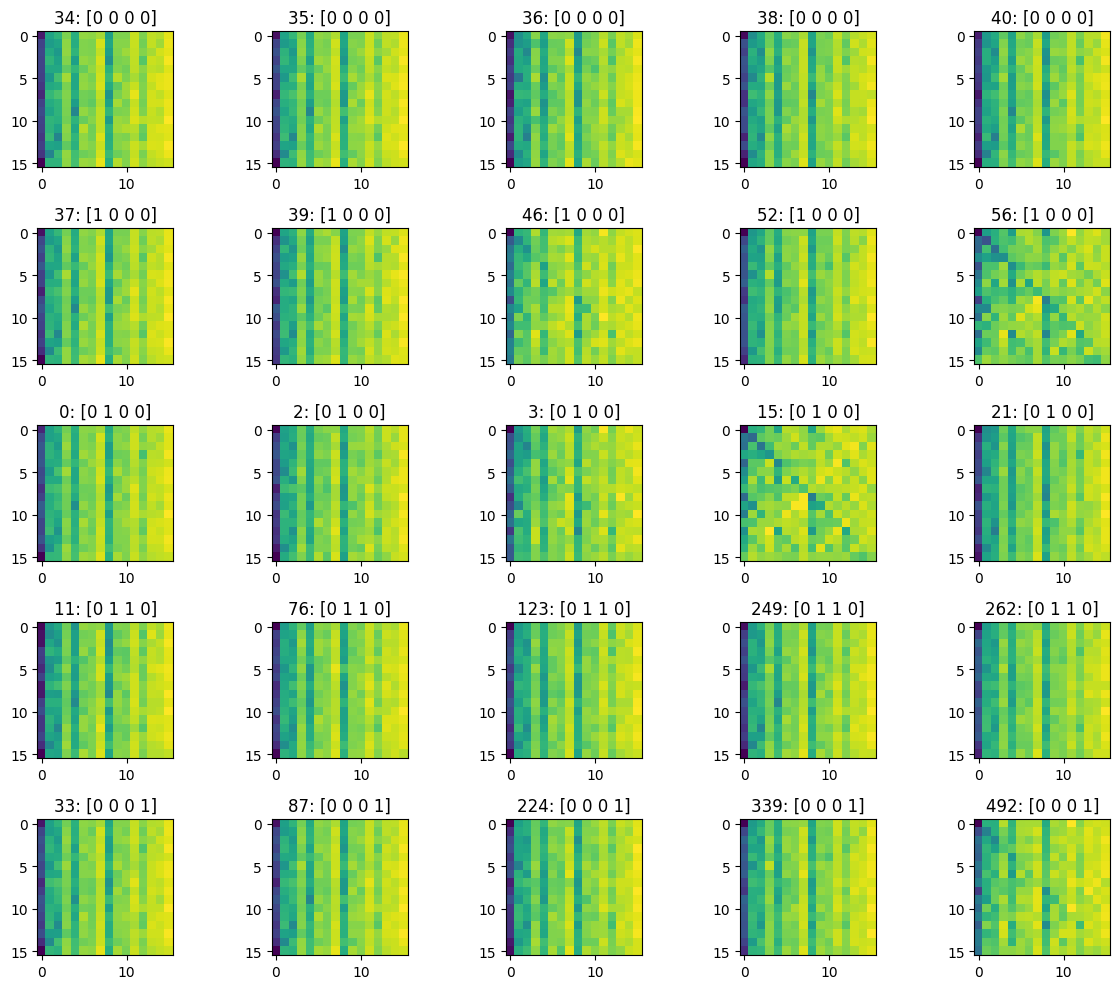

In [ ]:
def get_indexes(phenotype, cap=True):
  indicies = [index for index, pheno in enumerate(y) if np.all(pheno == phenotype)]
  return indicies[:5] if cap else indicies

phenotypes = [ # TODO just make this an identity matrix
    [0,0,0,0],
    [1,0,0,0],
    [0,1,0,0],
    [0,1,1,0],
    [0,0,0,1],
]

indexes = []
for i in [get_indexes(ph) for ph in phenotypes]:
  indexes += i

# just add the AB's in post
plot_group(indexes)

Singluar Antibiotic resistance genomes' fcgr image showing no immediant patterns

# Model Iteration
Utility functions used for model evaluation

In [ ]:
METRICS = [
      keras.metrics.CategoricalCrossentropy(name='cross entropy'),
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [ ]:
def eval_tf(model, X_test, y_test, threshold=0.5, highlight=False):
  # threshold = 0.6
  y_pred = model.predict(X_test)
  y_pred_truncate = (y_pred >= threshold).astype(int)
  print(y_pred_truncate[:5])

  eval_skl(model, X_test, y_test,
          y_pred=y_pred_truncate, highlight=True)

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

def prec_recall_curve(model, y_pred, y_test):
  # y_pred = model.predict(X_test)

  precision = {}
  recall = {}
  auc_scores = {}
  for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    auc_scores[i] = auc(recall[i], precision[i])

  plt.figure()
  for i in range(4):
    plt.plot(recall[i], precision[i],
             label={ordered_AB_names[i]})

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()
  plt.show()

  for i, ab in enumerate(ordered_AB_names):
    print(f"{ordered_AB_names[i]}: AUC-PR = {auc_scores[i]:.2f}")

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
import itertools
import matplotlib as mpl


def eval_skl(
    model, X, y,
    cross_val=False,
    y_pred=None,
    cv=3,
    highlight=False
):

  if y_pred is None:
    if cross_val is True:
      y_pred = cross_val_predict(model, X, y, cv=3)
    else:
      y_pred = model.predict(X)

  # f1 = p*r / p+r
  av_f1 = f1_score(y, y_pred, average="weighted")
  print(f"weighted average f1: {av_f1:.3f}")

  print("Classification Report:")
  print(classification_report(y, y_pred))

  mcm = multilabel_confusion_matrix(y, y_pred)
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
  plt.subplots_adjust(hspace=0.5)

  for i, ax in enumerate(axes.flatten()):
    matrix = mcm[i]
    im = ax.imshow(matrix, interpolation="nearest", cmap=mpl.colormaps['Reds'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(title=ordered_AB_names[i],
          ylabel='True label',
          xlabel='Predicted label')

    for row, col in itertools.product(
        range(matrix.shape[0]), range(matrix.shape[1])
    ):

      if highlight:
        color = "green"
      else:
        color = "white" if (col + row) % 2 == 0 else "black"

      ax.text(col, row, f"{matrix[row, col]}",
              horizontalalignment="center", color=color)

    ax.set_xticks([])
    ax.set_yticks([])

  plt.tight_layout()
  plt.show()

  return y_pred

  # prec_recall_curve(model, np.array(y_pred), np.array(y))

# DNN
Deep nueral network trained on an the selective dataset.

In [ ]:
n_features = 200

dnn_data = [np.array(set_) for set_ in selective_dataset(n_features=n_features)]
X_dnn_train, X_dnn_test, y_dnn_train, y_dnn_test = dnn_data

132


In [ ]:
def create_dnn(metrics=METRICS, n_features=600):
  DefaultDense = partial(layers.Dense, activation=layers.LeakyReLU(alpha=0.2),
                         kernel_initializer="he_uniform",
                         kernel_regularizer= keras.regularizers.l2(0.01)
                         )

  model = keras.Sequential([
      keras.Input(shape=(n_features)),
      # layers.Flatten(),
      DefaultDense(256),
      layers.Dropout(0.5),
      # layers.BatchNormalization(),
      DefaultDense(128),
      # layers.BatchNormalization(),
      layers.Dropout(0.5),
      DefaultDense(64),
      layers.Dense(4, activation='sigmoid')
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=3e-4),
      loss='binary_crossentropy',
      metrics=metrics
  )

  return model

model = create_dnn(n_features=n_features)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               51456     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 92,868
Trainable params: 92,868
Non-traina

Epoch 1/300
30/30 [==============================] - 9s 65ms/step - loss: 10.6468 - cross entropy: 9.7179 - Brier score: 0.3839 - tp: 988.0000 - fp: 865.0000 - tn: 1018.0000 - fn: 917.0000 - accuracy: 0.2408 - precision: 0.5332 - recall: 0.5186 - auc: 0.5479 - prc: 0.5431 - val_loss: 9.4699 - val_cross entropy: 3.8682 - val_Brier score: 0.2630 - val_tp: 232.0000 - val_fp: 169.0000 - val_tn: 156.0000 - val_fn: 91.0000 - val_accuracy: 0.6728 - val_precision: 0.5786 - val_recall: 0.7183 - val_auc: 0.6541 - val_prc: 0.6353
Epoch 2/300
30/30 [==============================] - 1s 21ms/step - loss: 9.5537 - cross entropy: 5.5936 - Brier score: 0.2972 - tp: 1098.0000 - fp: 720.0000 - tn: 1163.0000 - fn: 807.0000 - accuracy: 0.2249 - precision: 0.6040 - recall: 0.5764 - auc: 0.6310 - prc: 0.6132 - val_loss: 9.0436 - val_cross entropy: 3.1129 - val_Brier score: 0.2233 - val_tp: 227.0000 - val_fp: 132.0000 - val_tn: 193.0000 - val_fn: 96.0000 - val_accuracy: 0.6914 - val_precision: 0.6323 - val_r

<Axes: >

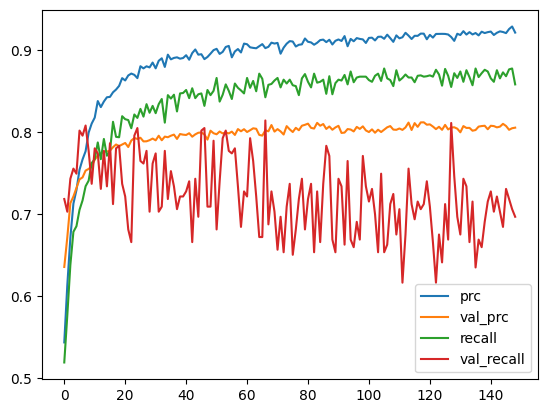

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

EPOCHS = 300
BATCH_SIZE = 32

def learning_rate_scheduler(epoch, lr, n=2):
  if epoch < n:
    return lr
  else:
    # drastically slow lr after epoch n
    return lr * tf.math.exp(-0.1)

learning_rate_scheduler = LearningRateScheduler(learning_rate_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir="./logs")
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)


mlp_history = model.fit(X_dnn_train, y_dnn_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_dnn_test, y_dnn_test),
                        callbacks=[
                            early_stopping_cb,
                            tensorboard_cb,
                            # learning_rate_scheduler,
                            ])

df = pd.DataFrame(mlp_history.history)
(df[['prc', 'val_prc', 'recall', 'val_recall']].plot())

6/6 [==============================] - 0s 5ms/step


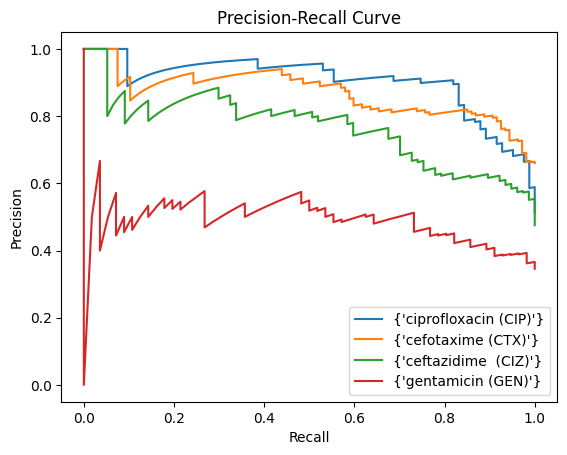

ciprofloxacin (CIP): AUC-PR = 0.90
cefotaxime (CTX): AUC-PR = 0.87
ceftazidime  (CIZ): AUC-PR = 0.76
gentamicin (GEN): AUC-PR = 0.49


In [ ]:
prec_recall_curve(model, model.predict(X_dnn_test), y_dnn_test)

6/6 [==============================] - 0s 4ms/step
[[0 1 1 0]
 [1 0 0 0]
 [1 1 1 1]
 [1 1 1 1]
 [0 1 1 0]]
weighted average f1: 0.721
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        83
           1       0.82      0.65      0.73       107
           2       0.75      0.68      0.71        77
           3       0.49      0.64      0.56        56

   micro avg       0.72      0.71      0.72       323
   macro avg       0.72      0.71      0.71       323
weighted avg       0.74      0.71      0.72       323
 samples avg       0.43      0.49      0.44       323



Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.


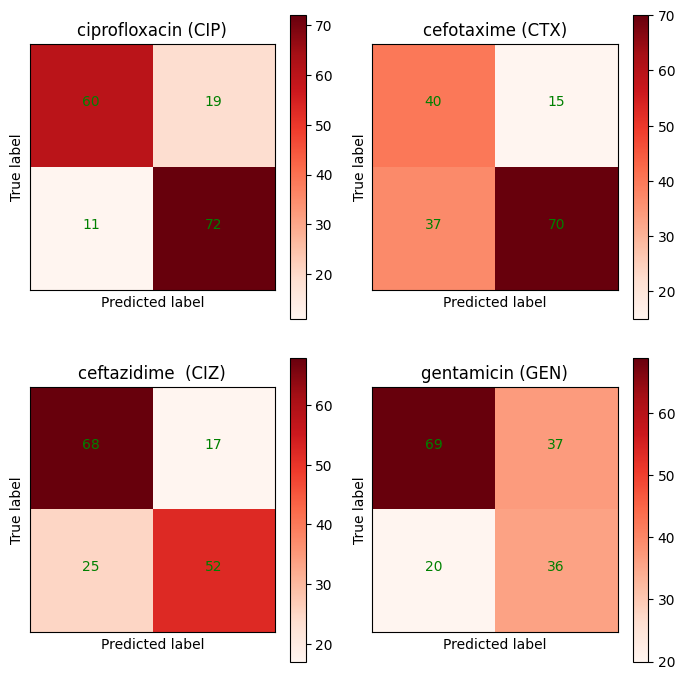

In [ ]:
eval_tf(model, X_dnn_test, y_dnn_test, threshold=0.5, highlight=True)

In [ ]:



def save_tf(model, model_name):
  dir = '/content/drive/MyDrive/ecoli_models/'
  model_dir = dir + model_name
  !mkdir /content/drive/MyDrive/ecoli_models/

  if os.path.exists(model_dir):
      current_time = datetime.now().strftime('%Y%m%d%H%M%S')
      os.rename(model_dir, dir + f'old_{current_time}_{model_name}')

  save_model(model, model_dir)
  !du -sh /content/drive/MyDrive/ecoli_models/DNN

In [ ]:
save_tf(model, "DNN")

mkdir: cannot create directory ‘/content/drive/MyDrive/ecoli_models/’: File exists


1.4M	/content/drive/MyDrive/ecoli_models/DNN


In [ ]:
pip install alibi[tensorflow] 2>&1 >/dev/null

In [ ]:
model = load_model('/content/drive/MyDrive/ecoli_models/DNN')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               51456     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 92,868
Trainable params: 92,868
Non-traina

In [ ]:
# https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
# https://arxiv.org/abs/1703.01365 <- original paper
# https://github.com/SeldonIO/alibi/blob/master/doc/source/methods/IntegratedGradients.ipynb
from alibi.explainers import IntegratedGradients
ig  = IntegratedGradients(model,
                          layer=None,
                          # taget_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

In [ ]:
np.array(model.predict(X_dnn_train) > 0.5, dtype=np.int32)

30/30 [==============================] - 0s 7ms/step


array([[1, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

In [ ]:
explanation = ig.explain(X_dnn_train, # X
                         baselines=None,
                         target=np.array(model.predict(X_dnn_train) > 0.5, dtype=np.int32))

attributions = explanation.attributions

30/30 [==============================] - 0s 2ms/step


ValueError: ignored

# DNN & FCGR

In [ ]:
X_fcgr_train, X_fcgr_test, y_fcgr_train, y_fcgr_test = fcgr_dataset
for i in fcgr_dataset:
  print(i.shape)

(887, 64, 64)
(222, 64, 64)
(887, 4)
(222, 4)


In [ ]:
DefaultDense = partial(layers.Dense, activation=layers.LeakyReLU(alpha=0.2),
                        kernel_initializer="he_uniform",
                        kernel_regularizer= keras.regularizers.l2(0.01)
                        )

model = keras.Sequential([
    keras.Input(shape=(64, 64)),
    layers.Flatten(),
    DefaultDense(256),
    layers.Dropout(0.5),
    # layers.BatchNormalization(),
    DefaultDense(128),
    # layers.BatchNormalization(),
    layers.Dropout(0.2),
    DefaultDense(64),
    layers.Dense(4, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-4),
    loss='binary_crossentropy',
    metrics=METRICS
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 4096)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               1048832   
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 4)                

Epoch 1/300
28/28 [==============================] - 3s 38ms/step - loss: 11.4908 - cross entropy: 12.4388 - Brier score: 0.3706 - tp: 1280.0000 - fp: 1015.0000 - tn: 1225.0000 - fn: 916.0000 - accuracy: 0.3589 - precision: 0.5577 - recall: 0.5829 - auc: 0.5598 - prc: 0.5466 - val_loss: 9.5040 - val_cross entropy: 3.2423 - val_Brier score: 0.2661 - val_tp: 149.0000 - val_fp: 81.0000 - val_tn: 327.0000 - val_fn: 331.0000 - val_accuracy: 0.1847 - val_precision: 0.6478 - val_recall: 0.3104 - val_auc: 0.6154 - val_prc: 0.5966
Epoch 2/300
28/28 [==============================] - 0s 17ms/step - loss: 9.9112 - cross entropy: 6.2429 - Brier score: 0.3574 - tp: 919.0000 - fp: 900.0000 - tn: 932.0000 - fn: 797.0000 - accuracy: 0.3078 - precision: 0.5052 - recall: 0.5355 - auc: 0.5359 - prc: 0.5155 - val_loss: 9.2636 - val_cross entropy: 3.1127 - val_Brier score: 0.2514 - val_tp: 154.0000 - val_fp: 86.0000 - val_tn: 322.0000 - val_fn: 326.0000 - val_accuracy: 0.1892 - val_precision: 0.6417 - val_

<Axes: >

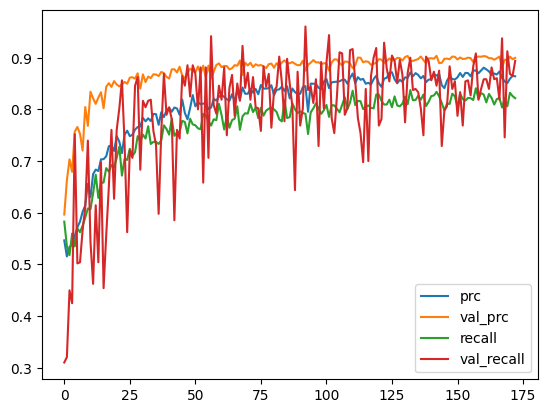

In [ ]:
EPOCHS = 300
BATCH_SIZE = 32

tensorboard_cb = keras.callbacks.TensorBoard(log_dir="./logs")
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)

cnn_history = model.fit(X_fcgr_train, y_fcgr_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_fcgr_test, y_fcgr_test),
                    callbacks=[early_stopping_cb, tensorboard_cb])

df = pd.DataFrame(cnn_history.history)
(df[['prc', 'val_prc', 'recall', 'val_recall']].plot())

7/7 [==============================] - 0s 4ms/step


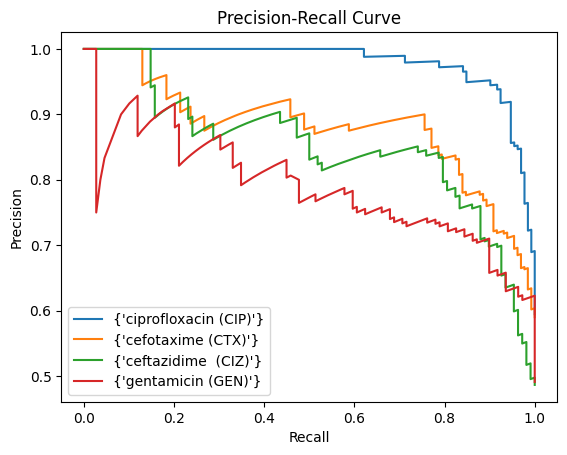

ciprofloxacin (CIP): AUC-PR = 0.98
cefotaxime (CTX): AUC-PR = 0.88
ceftazidime  (CIZ): AUC-PR = 0.85
gentamicin (GEN): AUC-PR = 0.79


In [ ]:
prec_recall_curve(model, model.predict(X_fcgr_test), y_fcgr_test)

7/7 [==============================] - 0s 4ms/step
[[1 1 1 1]
 [1 1 1 1]
 [1 1 0 1]
 [1 1 1 1]
 [1 1 1 1]]
weighted average f1: 0.832
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       132
           1       0.80      0.84      0.82       131
           2       0.82      0.80      0.81       108
           3       0.73      0.79      0.76       109

   micro avg       0.82      0.85      0.83       480
   macro avg       0.82      0.84      0.83       480
weighted avg       0.82      0.85      0.83       480
 samples avg       0.51      0.57      0.52       480



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


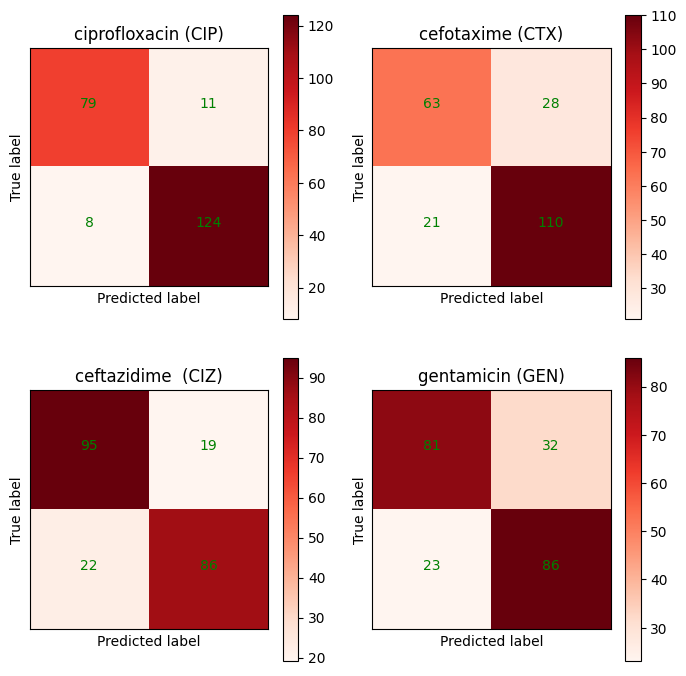

In [ ]:
eval_tf(model, X_fcgr_test, y_fcgr_test)

# GRU

In [ ]:
gru_data = [np.array(set_.copy()) for set_ in oversampled_dataset]
X_gru_train, X_gru_test, y_gru_train, y_gru_test = gru_data

In [ ]:
X_gru_test.shape, y_gru_test.shape

((162, 14971), (162, 4))

In [ ]:
n_features = 14971

model = keras.Sequential([
    keras.Input(shape=(14971, 1)), # switch for 1hot
    layers.GRU(units=32, return_sequences=False),
    layers.Dense(4, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=METRICS
)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 32)                3360      
                                                                 
 dense_9 (Dense)             (None, 4)                 132       
                                                                 
Total params: 3,492
Trainable params: 3,492
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
14/14 [==============================] - 123s 9s/step - loss: 0.6894 - cross entropy: 2.5518 - Brier score: 0.2480 - tp: 537.0000 - fp: 501.0000 - tn: 1334.0000 - fn: 1016.0000 - accuracy: 0.6600 - precision: 0.5173 - recall: 0.3458 - auc: 0.5504 - prc: 0.5002 - val_loss: 0.6791 - val_cross entropy: 2.7328 - val_Brier score: 0.2431 - val_tp: 154.0000 - val_fp: 118.0000 - val_tn: 207.0000 - val_fn: 169.0000 - val_accuracy: 0.7716 - val_precision: 0.5662 - val_recall: 0.4768 - val_auc: 0.5940 - val_prc: 0.5544
Epoch 2/20
14/14 [==============================] - 117s 8s/step - loss: 0.6827 - cross entropy: 2.5519 - Brier score: 0.2448 - tp: 500.0000 - fp: 403.0000 - tn: 1432.0000 - fn: 1053.0000 - accuracy: 0.8725 - precision: 0.5537 - recall: 0.3220 - auc: 0.5679 - prc: 0.5182 - val_loss: 0.6896 - val_cross entropy: 2.7476 - val_Brier score: 0.2482 - val_tp: 77.0000 - val_fp: 56.0000 - val_tn: 269.0000 - val_fn: 246.0000 - val_accuracy: 0.7531 - val_precision: 0.5789 - val_rec

<Axes: >

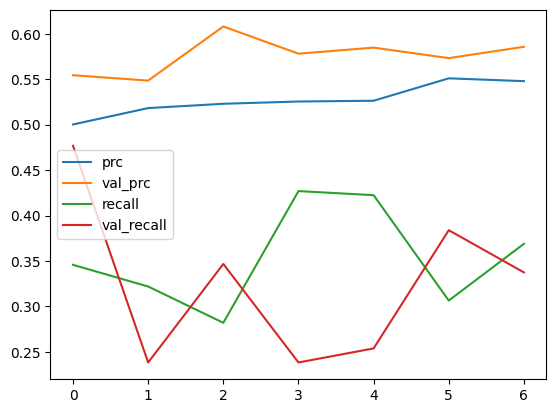

In [ ]:
EPOCHS = 20
BATCH_SIZE = 64

tensorboard_cb = keras.callbacks.TensorBoard(log_dir="./logs")
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=4,
    mode='max',
    restore_best_weights=True)

mlp_history = model.fit(X_gru_train, y_gru_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_gru_test, y_gru_test),
                        callbacks=[early_stopping_cb, tensorboard_cb])

df = pd.DataFrame(mlp_history.history)
(df[['prc', 'val_prc', 'recall', 'val_recall']].plot())

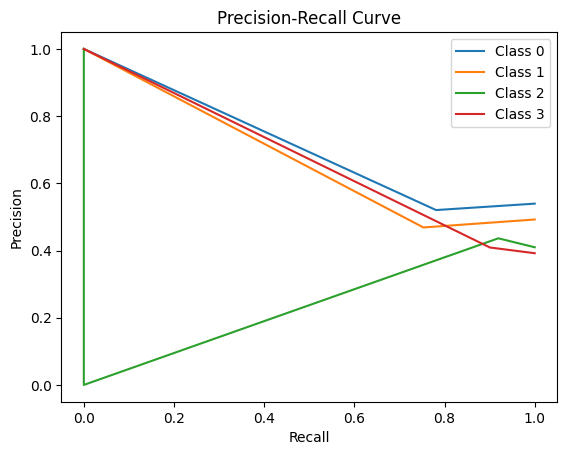

ab: AUC = 0.71
ab: AUC = 0.67
ab: AUC = 0.23
ab: AUC = 0.67


In [ ]:
prec_recall_curve(model, X_gru_train, y_gru_train)

non functional

# CNN & FCGR


In [ ]:
X_fcgr_train, X_fcgr_test, y_fcgr_train, y_fcgr_test = fcgr_dataset
for i in fcgr_dataset:
  print(i.shape)

(887, 64, 64)
(222, 64, 64)
(887, 4)
(222, 4)


In [ ]:
feature_shape = (64, 64, 1)

def create_cnn_2d(metrics=METRICS):
  """ 2d cnn w/ l2, batch norm & drop out """
  default_conv2d = partial(layers.Conv2D, kernel_size=3, padding='same',
                          activation='relu', kernel_initializer='he_normal',
                         # kernel_regularizer=keras.regularizers.l2(0.7)
                         )

  model = keras.Sequential([

    keras.Input(shape=feature_shape),
    default_conv2d(32),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.MaxPooling2D((2, 2)),
    default_conv2d(64),
    layers.BatchNormalization(),

    layers.MaxPooling2D((2, 2)),
    default_conv2d(128),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='sigmoid')

  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=2e-4),
      # loss=keras.losses.CategoricalCrossentropy(),
      loss='binary_crossentropy',
      metrics=metrics
  )

  return model


model = create_cnn_2d() # init bias
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_9 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_10 (Ba  (None, 32, 32, 64)       

Epoch 1/300
28/28 [==============================] - 12s 319ms/step - loss: 0.8149 - cross entropy: 3.4584 - Brier score: 0.2734 - tp: 880.0000 - fp: 767.0000 - tn: 1065.0000 - fn: 836.0000 - accuracy: 0.2683 - precision: 0.5343 - recall: 0.5128 - auc: 0.5517 - prc: 0.5262 - val_loss: 0.6920 - val_cross entropy: 2.9982 - val_Brier score: 0.2494 - val_tp: 193.0000 - val_fp: 115.0000 - val_tn: 293.0000 - val_fn: 287.0000 - val_accuracy: 0.1261 - val_precision: 0.6266 - val_recall: 0.4021 - val_auc: 0.5370 - val_prc: 0.5906
Epoch 2/300
28/28 [==============================] - 12s 419ms/step - loss: 0.6749 - cross entropy: 2.7774 - Brier score: 0.2407 - tp: 846.0000 - fp: 613.0000 - tn: 1219.0000 - fn: 870.0000 - accuracy: 0.4104 - precision: 0.5798 - recall: 0.4930 - auc: 0.6081 - prc: 0.5921 - val_loss: 0.6839 - val_cross entropy: 2.9958 - val_Brier score: 0.2454 - val_tp: 149.0000 - val_fp: 93.0000 - val_tn: 315.0000 - val_fn: 331.0000 - val_accuracy: 0.8514 - val_precision: 0.6157 - va

<Axes: >

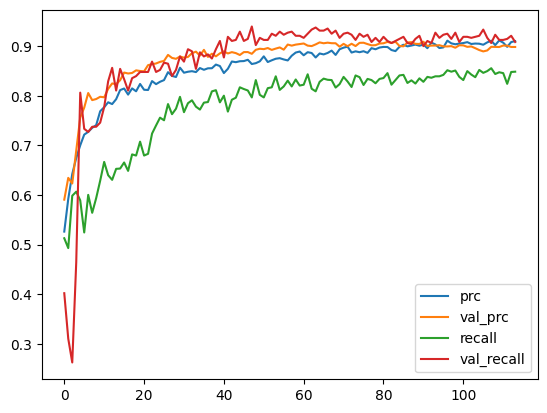

In [ ]:
EPOCHS = 300 # relying on early stopping
BATCH_SIZE = 32
# TOFO lr scheduler

tensorboard_cb = keras.callbacks.TensorBoard(log_dir="./logs")
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)

cnn_history = model.fit(X_fcgr_train, y_fcgr_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_fcgr_test, y_fcgr_test),
                    callbacks=[early_stopping_cb, tensorboard_cb])

df = pd.DataFrame(cnn_history.history)
(df[['prc', 'val_prc', 'recall', 'val_recall']].plot())

(<Axes: >, <Axes: >, <Axes: >)

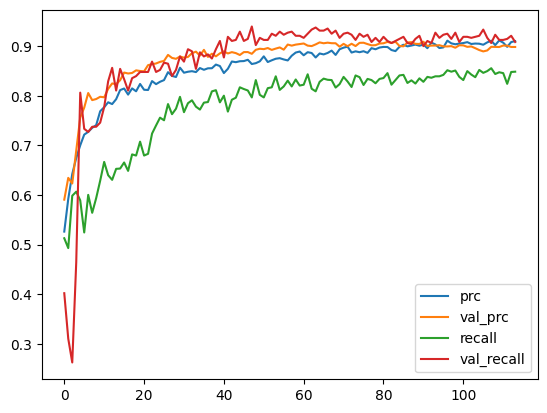

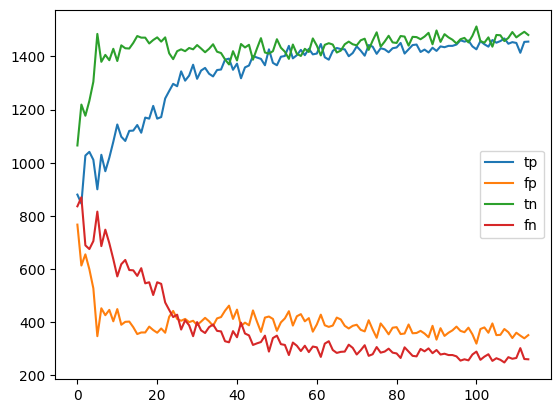

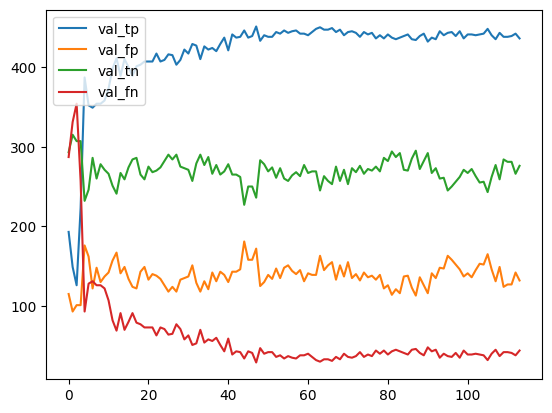

In [ ]:
(df[['prc', 'val_prc', 'recall', 'val_recall']].plot(),
 df[['tp', 'fp', 'tn', 'fn']].plot(),
 df[['val_tp', 'val_fp', 'val_tn', 'val_fn']].plot())

In [ ]:
model.predict(X_fcgr_test[34:47])

1/1 [==============================] - 0s 128ms/step


array([[9.98966098e-01, 9.35496032e-01, 9.10769701e-01, 7.81644642e-01],
       [9.99561012e-01, 9.52204764e-01, 9.31880414e-01, 8.07736158e-01],
       [3.18958938e-01, 4.54929382e-01, 3.75421613e-01, 4.10965502e-01],
       [9.98987734e-01, 9.36085463e-01, 9.10931528e-01, 7.81906247e-01],
       [8.80089462e-01, 5.20747721e-01, 3.14018101e-01, 5.44254363e-01],
       [9.99999881e-01, 9.96897876e-01, 5.04510863e-05, 9.99984145e-01],
       [7.95211971e-01, 5.91124773e-01, 5.51821589e-01, 5.57855904e-01],
       [2.05232147e-02, 4.53921929e-02, 2.17895452e-02, 1.33970585e-02],
       [4.15144950e-01, 9.62554336e-01, 9.23032939e-01, 6.68030143e-01],
       [9.98974621e-01, 9.35815275e-01, 9.10517216e-01, 7.81440914e-01],
       [9.99932170e-01, 9.85755980e-01, 9.49296892e-01, 6.25780225e-01],
       [4.92128998e-01, 5.22021294e-01, 5.10125637e-01, 5.05271852e-01],
       [9.09241855e-01, 4.09861326e-01, 2.52808809e-01, 2.39653125e-01]],
      dtype=float32)

In [ ]:
pd.DataFrame(y).sum()

0    620
1    602
2    486
3    488
dtype: int64

7/7 [==============================] - 0s 53ms/step


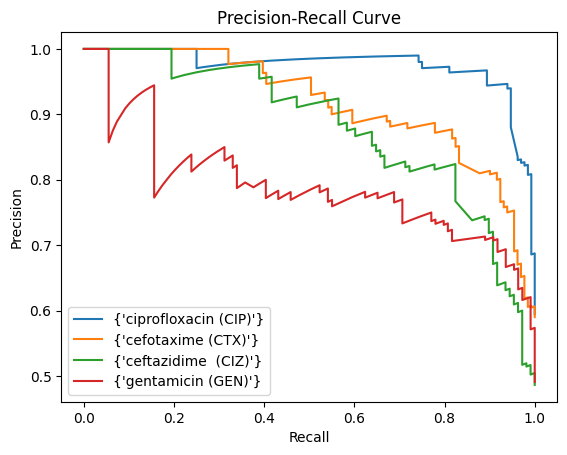

ciprofloxacin (CIP): AUC-PR = 0.97
cefotaxime (CTX): AUC-PR = 0.92
ceftazidime  (CIZ): AUC-PR = 0.88
gentamicin (GEN): AUC-PR = 0.79


In [ ]:
prec_recall_curve(model, model.predict(X_fcgr_test), y_fcgr_test)

7/7 [==============================] - 1s 86ms/step
[[1 1 1 1]
 [1 1 1 1]
 [1 0 0 1]
 [1 1 1 1]
 [1 1 1 1]]
weighted average f1: 0.848
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       132
           1       0.81      0.91      0.86       131
           2       0.74      0.89      0.81       108
           3       0.71      0.89      0.79       109

   micro avg       0.79      0.91      0.85       480
   macro avg       0.79      0.91      0.84       480
weighted avg       0.79      0.91      0.85       480
 samples avg       0.56      0.64      0.58       480



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


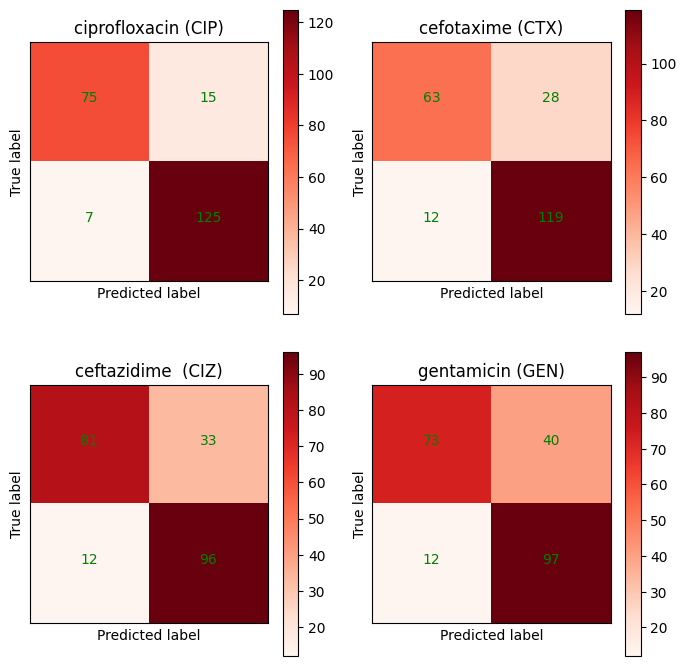

In [ ]:
eval_tf(model, X_fcgr_test, y_fcgr_test)

# RF

In [ ]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = oversampled_dataset
X_rf = np.concatenate([X_rf_train, X_rf_test]) # using cross validation => no test set
y_rf = np.concatenate([y_rf_train, y_rf_test])
X_rf.shape, y_rf.shape

((1109, 14971), (1109, 4))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf.fit(X_rf_train, y_rf_train)

RandomForestClassifier(random_state=0)

In [ ]:
len(rf.estimators_)

100

weighted average f1: 0.861
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       618
           1       0.80      0.87      0.83       591
           2       0.85      0.85      0.85       482
           3       0.75      0.89      0.81       488

   micro avg       0.83      0.89      0.86      2179
   macro avg       0.83      0.89      0.86      2179
weighted avg       0.83      0.89      0.86      2179
 samples avg       0.57      0.60      0.57      2179



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


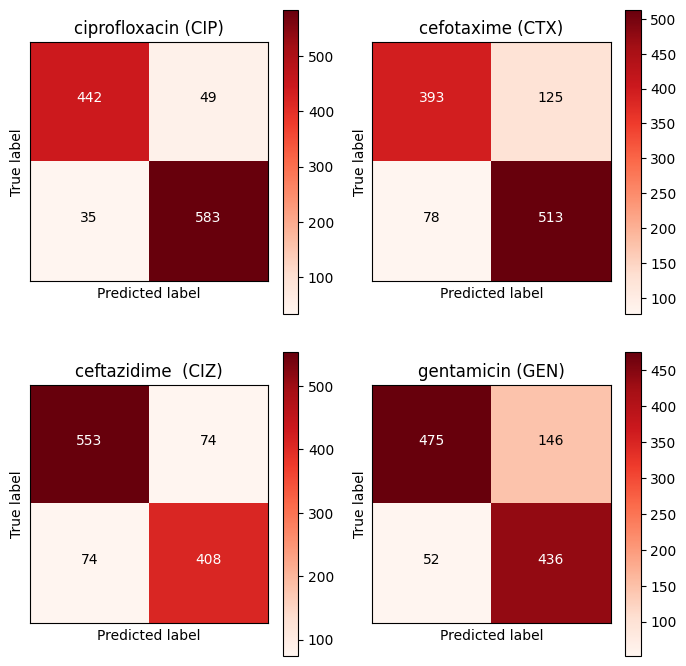

In [ ]:
eval_skl(rf, X_rf, y_rf, cross_val=True)

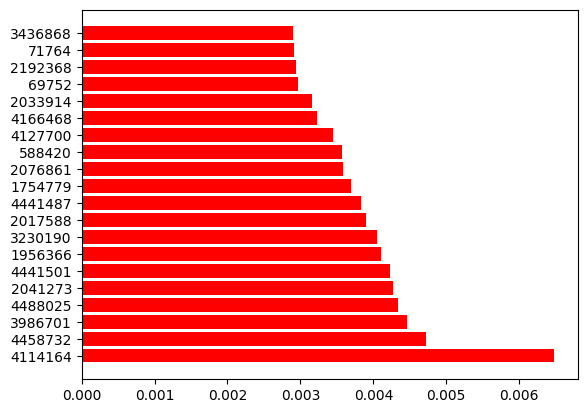

[(4114164, 0.006476117119073388),
 (4458732, 0.004721915942430269),
 (3986701, 0.004459990811888473),
 (4488025, 0.004333457573144362),
 (2041273, 0.0042677889834834585),
 (4441501, 0.004230306663078709),
 (1956366, 0.00410357797181219),
 (3230190, 0.004056373340686007),
 (2017588, 0.0039042395844799405),
 (4441487, 0.003829291420322967),
 (1754779, 0.0036954740019614642),
 (2076861, 0.0035880615764035083),
 (588420, 0.0035726658815182694),
 (4127700, 0.0034474009180729187),
 (4166468, 0.0032270710311247727),
 (2033914, 0.003157175756422102),
 (69752, 0.0029692234995160865),
 (2192368, 0.0029400470435142993),
 (71764, 0.0029069130158549095),
 (3436868, 0.00289309931736615),
 (4172893, 0.0027680501136708204),
 (2091462, 0.002753784175749698),
 (2792739, 0.0027302515897289176),
 (2313262, 0.0027067756231831082),
 (4419811, 0.0026878909131988348),
 (3538947, 0.0026652381082373456),
 (4124933, 0.0025966136235059693),
 (57837, 0.002491134754251624),
 (4230581, 0.0024547562540103277),
 (7812

In [ ]:
feature_importance(rf, cap=20)

# RF Grid search optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2],
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid, cv=3,
                           scoring=make_scorer(f1_score, average='macro'))

grid_search.fit(X_rf, y_rf) # cv

print(grid_search.best_params_)
print("best average f1 score: ", grid_search.best_score_)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
best average f1 score:  0.8520904621311453


weighted average f1: 0.870
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       629
           1       0.81      0.87      0.84       591
           2       0.85      0.85      0.85       484
           3       0.77      0.93      0.84       488

   micro avg       0.84      0.90      0.87      2192
   macro avg       0.84      0.90      0.87      2192
weighted avg       0.84      0.90      0.87      2192
 samples avg       0.57      0.60      0.57      2192



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


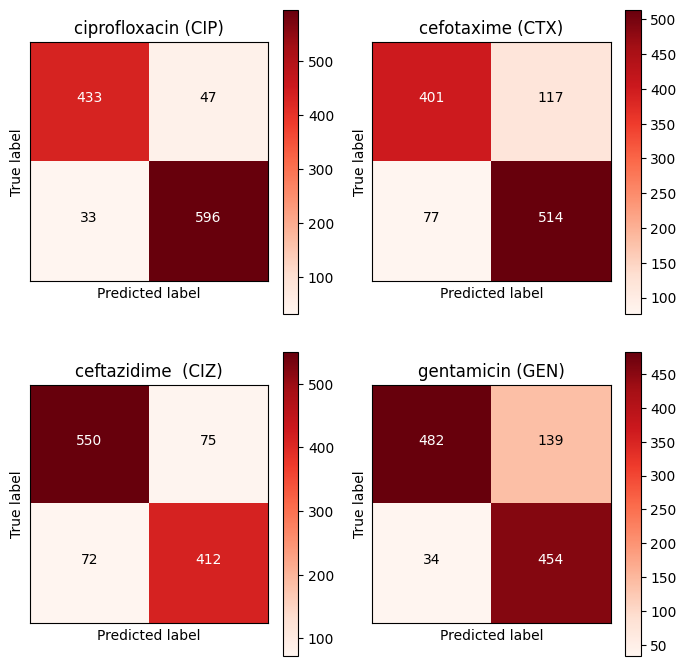

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 1, 0, 0],
       ...,
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 0]])

In [ ]:
best_rf = grid_search.best_estimator_
eval_skl(best_rf, X_rf, y_rf, cross_val=True)

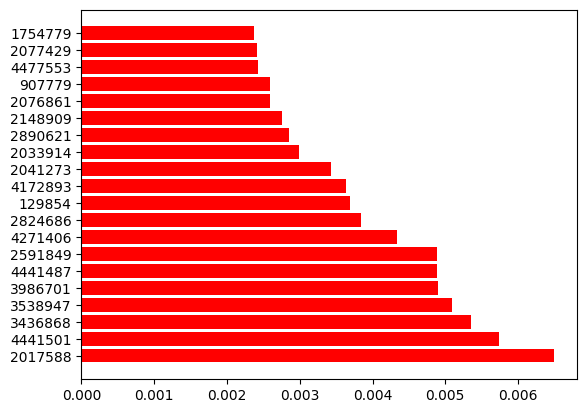

[(2017588, 0.006491779514982993),
 (4441501, 0.005736178875246547),
 (3436868, 0.005353311306952114),
 (3538947, 0.005085562367602449),
 (3986701, 0.0048987904505302295),
 (4441487, 0.004892487625196002),
 (2591849, 0.00488872793968271),
 (4271406, 0.004338157652548932),
 (2824686, 0.0038480863253505847),
 (129854, 0.0036890775269471134),
 (4172893, 0.0036421361026241867),
 (2041273, 0.0034248802731428065),
 (2033914, 0.0029932181220672215),
 (2890621, 0.00284959617215147),
 (2148909, 0.0027502519002564098),
 (2076861, 0.0025877347059103805),
 (907779, 0.002584366656910917),
 (4477553, 0.002421532325404087),
 (2077429, 0.0024091725431040485),
 (1754779, 0.0023706927131960697),
 (2655873, 0.002352759129960837),
 (4605418, 0.002293024959961123),
 (4428463, 0.0022884699105682987),
 (1440485, 0.00226410335693972),
 (4443644, 0.0022356511669206795),
 (2843800, 0.0021194618152348627),
 (4095950, 0.0020988857092489326),
 (3125223, 0.0020683513877727596),
 (4459543, 0.0020665463622439994),
 (4

In [ ]:
feature_importance(best_rf, cap=20)

In [ ]:
y_pred = cross_val_predict(best_rf, X_rf, y_rf, cv=3, method='predict_proba') # get probabilities
prec_recall_curve(best_rf, y_pred, y_rf)

TypeError: ignored

# RF as a Classifier Chain

In [ ]:
from sklearn.multioutput import ClassifierChain

chain_rf = ClassifierChain(RandomForestClassifier(random_state=0, min_samples_split=2, n_estimators=200), random_state=0)

weighted average f1: 0.868
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       629
           1       0.80      0.87      0.83       591
           2       0.84      0.86      0.85       484
           3       0.76      0.93      0.84       488

   micro avg       0.83      0.90      0.87      2192
   macro avg       0.83      0.90      0.86      2192
weighted avg       0.84      0.90      0.87      2192
 samples avg       0.57      0.60      0.57      2192



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


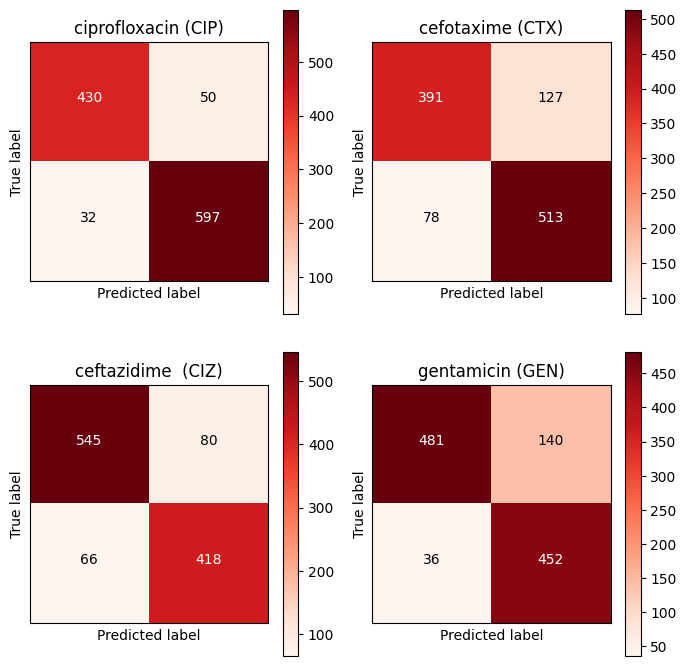

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 1., 0., 0.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 0.]])

In [ ]:
eval_skl(chain_rf, X_rf, y_rf, cross_val=True)

# SVC as a Classifier chain

In [ ]:
from sklearn.multioutput import ClassifierChain
from sklearn.svm import SVC

chain_svc = ClassifierChain(SVC(), random_state=0)

weighted average f1: 0.717
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       542
           1       0.74      0.79      0.77       521
           2       0.74      0.72      0.73       410
           3       0.51      0.36      0.42       388

   micro avg       0.74      0.71      0.73      1861
   macro avg       0.71      0.69      0.70      1861
weighted avg       0.73      0.71      0.72      1861
 samples avg       0.47      0.46      0.44      1861



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


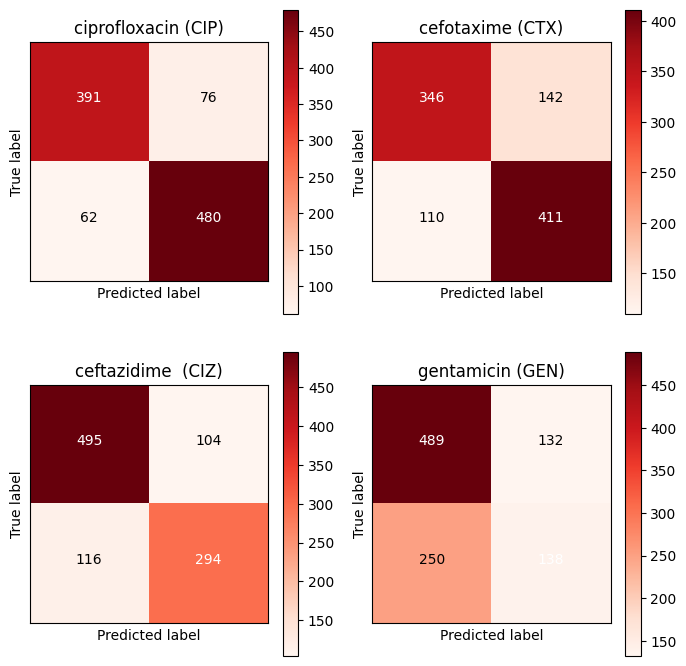

In [ ]:
eval_skl(chain_svc, X_rf, y_rf, cross_val=True, cv=3)

very weak

# Stacking

In [ ]:
# use feature selected dataset
X_train, X_test, y_train, y_test = selective_oversampled_dataset
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
X.shape, y.shape

((1109, 600), (1109, 4))

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=0, min_samples_split=2, n_estimators=200)), # best params
        ('svc', MultiOutputClassifier(SVC(random_state=0, max_iter=10_000))),
        ('lr', MultiOutputClassifier(LogisticRegression(random_state=0, max_iter=10_000)))
    ],
    final_estimator = RandomForestClassifier(random_state=0)
)
stacking_clf

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=0)),
                               ('svc',
                                MultiOutputClassifier(estimator=SVC(max_iter=10000,
                                                                    random_state=0))),
                               ('lr',
                                MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000,
                                                                                   random_state=0)))],
                   final_estimator=RandomForestClassifier(random_state=0))

weighted average f1: 0.867
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       619
           1       0.84      0.84      0.84       612
           2       0.87      0.83      0.85       502
           3       0.82      0.84      0.83       488

   micro avg       0.87      0.86      0.87      2221
   macro avg       0.87      0.86      0.86      2221
weighted avg       0.87      0.86      0.87      2221
 samples avg       0.56      0.57      0.55      2221



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


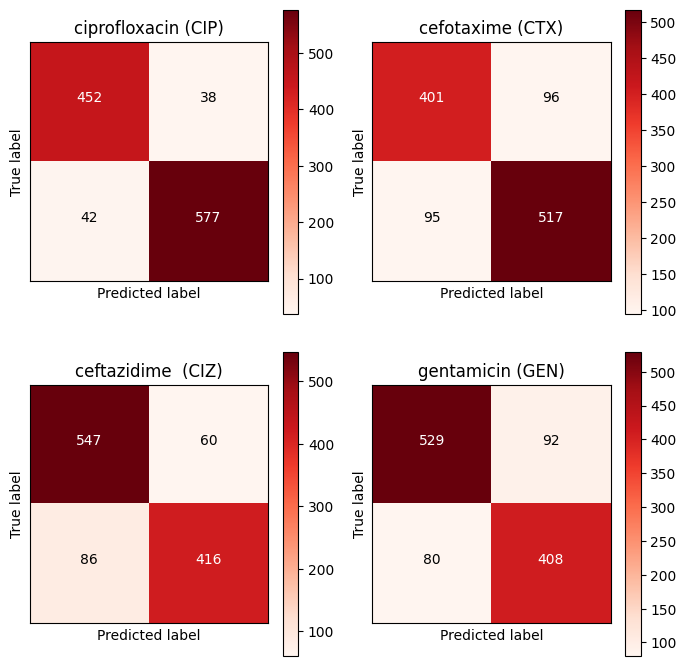

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 1, 0, 0],
       ...,
       [1, 1, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 0]])

In [ ]:
eval_skl(stacking_clf, X, y, cross_val=True, cv=3)

# Per AB feature importance

In [79]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = oversampled_dataset
X_rf = np.concatenate([X_rf_train, X_rf_test])
y_rf = np.concatenate([y_rf_train, y_rf_test])
X_rf.shape, y_rf.shape

((1109, 14971), (1109, 4))

top 50 decreases for  ciprofloxacin (CIP)


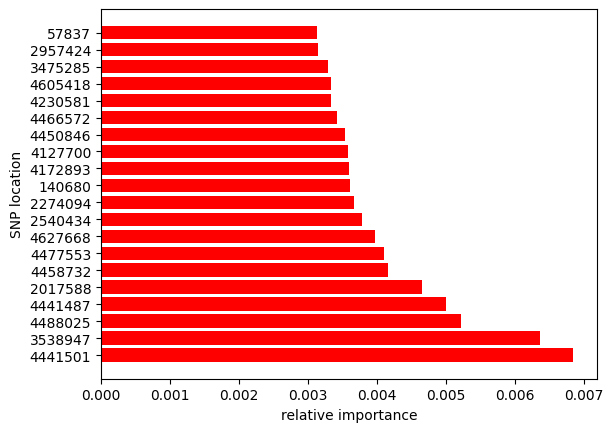

top 50 decreases for  cefotaxime (CTX)


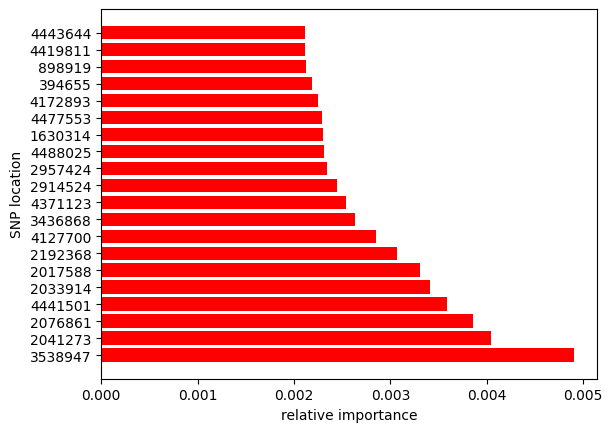

top 50 decreases for  ceftazidime  (CIZ)


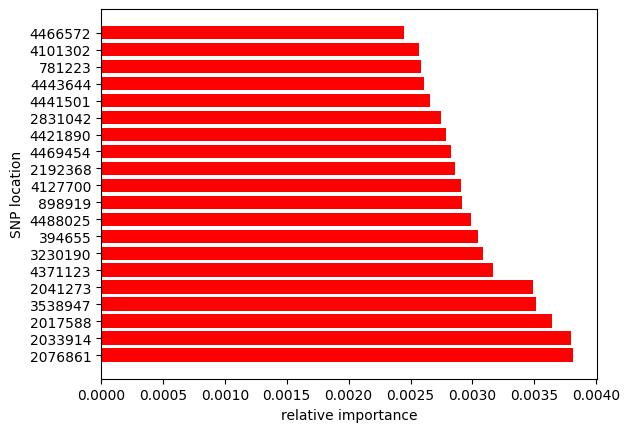

top 50 decreases for  gentamicin (GEN)


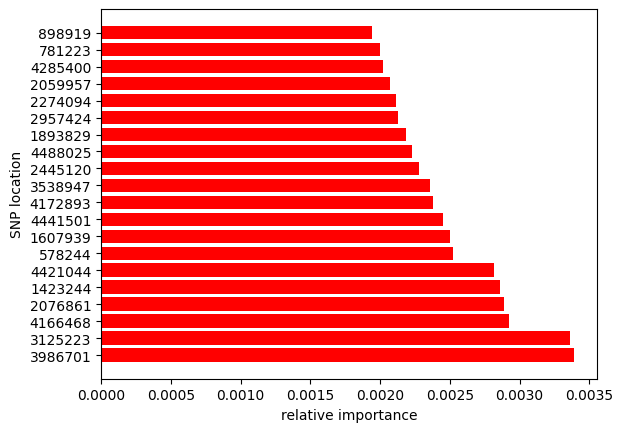

In [84]:
per_ab_importances = {}
for i, antibiotic in enumerate(ordered_AB_names):
  y_class = y_rf[:, i] # only train on ith col of output

  rf_classwize = RandomForestClassifier(random_state=0,
                                        min_samples_split=4,
                                        n_estimators=1000) # more

  rf_classwize.fit(X_rf, y_class) # throw away model - train on whole set

  print("top 50 decreases for ", antibiotic)
  per_ab_importances[antibiotic] = feature_importance(rf_classwize, cap=20)



Permutation importance was not possible (far to many features)